<img align="left" src="imgs/logo.jpg" width="50px" style="margin-right:10px">
# Snorkel Workshop: Extracting Spouse Relations <br> from the News
## Part 3: Training the Generative Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re
import numpy as np

# Connect to the database backend and initalize a Snorkel session
from lib.init import *
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels

from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

# I. Loading Labeling Matricies 

First we'll load our label matrices from notebook 2

In [2]:
from snorkel.annotations import LabelAnnotator

labeler = LabelAnnotator()
L_train = labeler.load_matrix(session, split=0)
L_dev   = labeler.load_matrix(session, split=1)

Now we set up and run the hyperparameter search, training our model with different hyperparamters and picking the best model configuration to keep. We'll set the random seed to maintain reproducibility.

Note that we are fitting our model's parameters to the training set generated by our labeling functions, while we are picking hyperparamters with respect to score over the development set labels which we created by hand.

# II: Unifying supervision

## A. Majority Vote
The most simple way to unify the output of all your LFs is by computed the _unweighted majority vote_. 

In [3]:
from lib.scoring import *

majority_vote_score(L_dev, L_gold_dev)

pos/neg    190:2621 6.8%/93.2%
precision  37.93
recall     57.89
f1         45.83


## B. Generative Model
In data programming, we use a more sophisitcated model to unify our labeling functions. We know that these labeling functions will not be perfect, and some may be quite low-quality, so we will _model_ their accuracies with a generative model, which Snorkel will help us easily apply.

This will ultimately produce a single set of **noise-aware training labels**, which we will then use to train an end extraction model in the next notebook.  For more technical details of this overall approach, see our [NIPS 2016 paper](https://arxiv.org/abs/1605.07723).

### 1. Training the Model
When training the generative model, we'll tune our hyperparamters using a simple grid search.  

In [4]:
from snorkel.learning import GenerativeModel
from snorkel.learning import RandomSearch, ListParameter, RangeParameter

# use grid search to optimize the generative model
step_size_param     = ListParameter('step_size', [0.1 / L_train.shape[0], 1e-5])
decay_param         = ListParameter('decay', [0.9, 0.95])
epochs_param        = ListParameter('epochs', [50, 100])

# search for the best model
param_grid = [step_size_param, decay_param, epochs_param]
searcher = RandomSearch(GenerativeModel, param_grid, L_train, n=4, lf_propensity=False)
%time gen_model, run_stats = searcher.fit(L_dev, L_gold_dev)

run_stats

Initialized RandomSearch search of size 4. Search space size = 8.
[1] Testing step_size = 1.00e-05, decay = 9.00e-01, epochs = 50
Inferred cardinality: 2
[GenerativeModel] F1 Score: 0.438818565401
[GenerativeModel] Model saved as <GenerativeModel_0>.
[2] Testing step_size = 1.00e-05, decay = 9.00e-01, epochs = 50
Inferred cardinality: 2
[GenerativeModel] F1 Score: 0.438818565401
[3] Testing step_size = 1.00e-05, decay = 9.50e-01, epochs = 50
Inferred cardinality: 2
[GenerativeModel] F1 Score: 0.420581655481
[4] Testing step_size = 4.49e-06, decay = 9.50e-01, epochs = 100
Inferred cardinality: 2
[GenerativeModel] F1 Score: 0.438818565401
[GenerativeModel] Model <GenerativeModel_0> loaded.
CPU times: user 3min 10s, sys: 1.07 s, total: 3min 11s
Wall time: 3min 11s


,step_size,decay,epochs,Prec.,Rec.,F1
0,0.000010,0.90,50,0.366197,0.547368,0.438819
1,0.000010,0.90,50,0.366197,0.547368,0.438819
3,0.000004,0.95,100,0.366197,0.547368,0.438819
2,0.000010,0.95,50,0.365759,0.494737,0.420582


### 2. Model Accuracies
These are the weights learned for each LF

In [5]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_distant_supervision,0,0.009249,0.009249,0.005692,22,4,0,0,0.846154,0.534587
LF_distant_supervision_last_names,1,0.013163,0.013163,0.008894,23,14,0,0,0.621622,0.540601
LF_husband_wife,2,0.091782,0.061544,0.018855,94,151,0,0,0.383673,0.558230
LF_husband_wife_left_window,3,0.069726,0.055141,0.013874,82,107,0,0,0.433862,0.542585
LF_same_last_name,4,0.024191,0.020277,0.016009,19,49,0,0,0.279412,0.537448
LF_no_spouse_in_sentence,5,0.608324,0.099964,0.019922,0,0,58,1582,0.964634,0.803176
LF_and_married,6,0.002134,0.002134,0.002134,2,4,0,0,0.333333,0.536297
LF_familial_relationship,7,0.118107,0.107079,0.030950,0,0,15,306,0.953271,0.584113
LF_family_left_window,8,0.075062,0.067236,0.012451,0,0,1,203,0.995098,0.566642
LF_other_relationship,9,0.008894,0.007115,0.002846,0,0,4,17,0.809524,0.529833


In [6]:
train_marginals = gen_model.marginals(L_train)

### 3. Plotting Marginal Probabilities
One immediate santity check  you can peform using the generative model is to visually examine the distribution of predicted training marginals. Ideally, there should get a bimodal distribution with large seperation between each peaks.

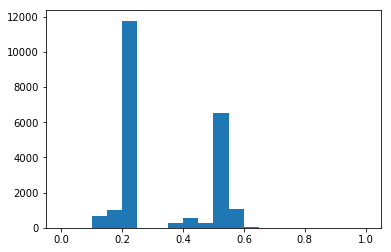

In [7]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20, range=(0.0, 1.0))
plt.show()

### 4. Generative Model Metrics

In [8]:
dev_marginals = gen_model.marginals(L_dev)
_, _, _, _ = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.547
Neg. class accuracy: 0.931
Precision            0.366
Recall               0.547
F1                   0.439
----------------------------------------
TP: 104 | FP: 180 | TN: 2441 | FN: 86



### 5. Saving our training labels

Finally, we'll save the `training_marginals`, which are our **"noise-aware training labels"**, so that we can use them in the next tutorial to train our end extraction model:

In [9]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 22254 marginals
CPU times: user 13.7 s, sys: 907 ms, total: 14.7 s
Wall time: 21.1 s


## 4. Structure Learning

We want to include the dependencies between our LFs when training the generative model. Snorkel makes it easy to do this! `DependencySelector` runs a fast structure learning algorithm over the matrix of LF outputs to identify a set of likely dependencies. 

In [ ]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.3)
print len(deps)

Now we'll train the generative model, using the `deps` argument to account for the learned dependencies. We'll also model LF propensity here, unlike the intro tutorial. In addition to learning the accuracies of the LFs, this also learns their likelihood of labeling an example.

In [ ]:
# search for the best model
searcher = RandomSearch(GenerativeModel, param_grid, L_train, n=4, lf_propensity=False)
%time gen_model, run_stats = searcher.fit(L_dev, L_gold_dev, deps=deps)
run_stats

In [ ]:
train_marginals = gen_model.marginals(L_train)

In [ ]:
plt.hist(train_marginals, bins=20, range=(0.0, 1.0))
plt.show()

In [ ]:
dev_marginals = gen_model.marginals(L_dev)
_, _, _, _ = gen_model.error_analysis(session, L_dev, L_gold_dev)

In [ ]:
save_marginals(session, L_train, train_marginals)